In [1]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
from scipy.special import expit as logistic
import pandas as pd
import matplotlib.pyplot as plt

# Hierarchical Modeling
- By modeling each group independently, we assume that groups are uncorrelated
- Hierarchical models are useful when dealing with data that can be described as grouped or with different levels
- Natural way of sharing information between groups. Built by assigning priors to priors
- Shrinkage: Estimates of each subgroup will be biased by the estimates of the rest of the groups

## Example 1

In [3]:
cs_data = pd.read_csv('data/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [4]:
cs_data.head()

,ID,aa,theo,exp
0,1BM8,ILE,61.18,58.27
1,1BM8,TYR,56.95,56.18
2,1BM8,SER,56.35,56.84
3,1BM8,ALA,51.96,51.01
4,1BM8,ARG,56.54,54.64


In [5]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


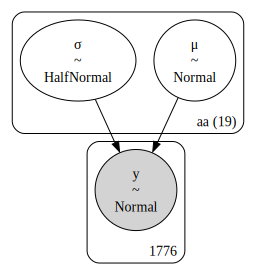

In [9]:
pm.model_to_graphviz(cs_nh)

In [6]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10) ## All means come from the same distribution
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


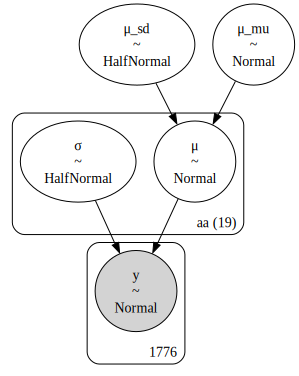

In [8]:
pm.model_to_graphviz(cs_h)

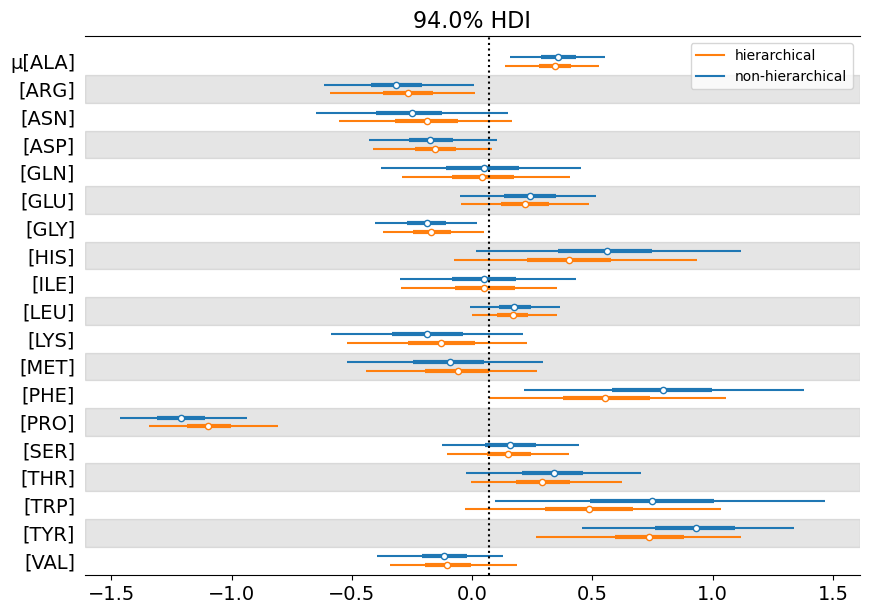

In [10]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['non-hierarchical', 'hierarchical'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

- Hierarchical model estimates are pulled towards the mean

## Example 2

In [12]:
d = pd.read_csv('data/reedfrogs.csv', sep=",")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [13]:
with pm.Model() as model_frogs:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 1.)
    σ = pm.HalfNormal('σ', 10.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ, shape=d.shape[0])
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # logistic transform
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    idata_frogs = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, σ, α_tanque]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


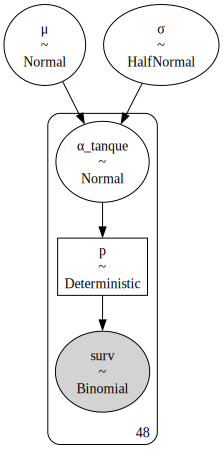

In [14]:
pm.model_to_graphviz(model_frogs)

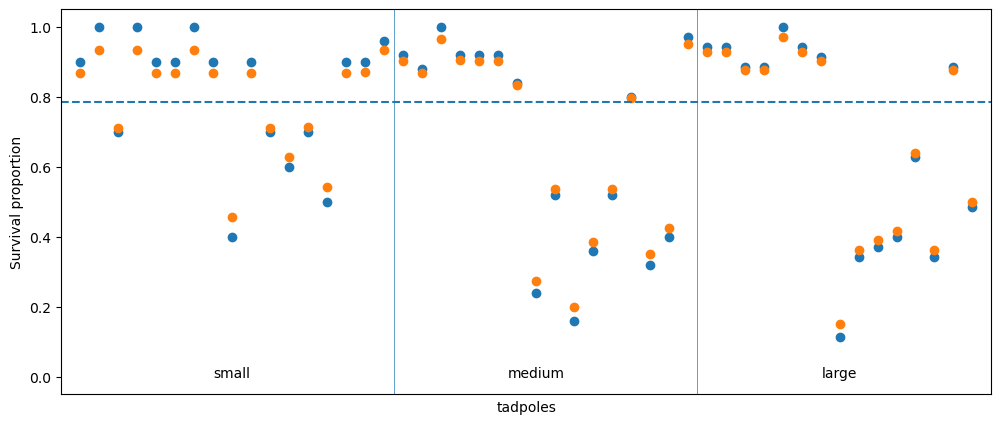

In [15]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

post_r = az.extract(idata_frogs)

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), post_r['p'].mean("sample"), color='C1')
ax.hlines(logistic(post_r['μ'].median("sample")), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('small', 'medium', 'large')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tadpoles')
ax.set_ylabel('Survival proportion')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

In [17]:
N = [30, 30, 30]
G = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
with pm.Model() as modelo_j:
    # hypyerpriors
    μ = pm.Beta('μ', 1, 1)
    ν = pm.HalfNormal('ν', 10)
    # prior
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N))
    # likelihood
    y = pm.Binomial('y',n=1, p=θ[group_idx], observed=data)

    idata_j = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, ν, θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


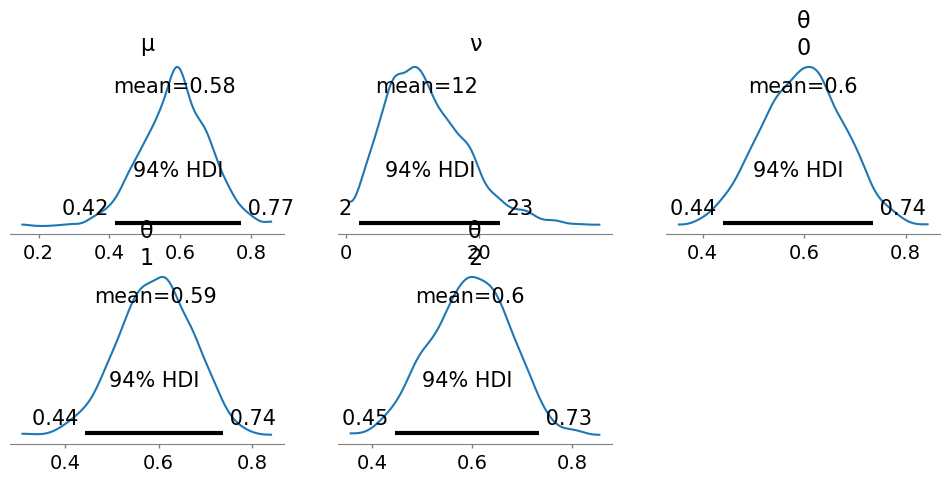

In [19]:
az.plot_posterior(idata_j, figsize=(12, 5));

In [18]:
az.summary(idata_j, kind="stats")

,mean,sd,hdi_3%,hdi_97%
μ,0.585,0.094,0.416,0.770
ν,12.132,6.124,2.006,23.164
θ[0],0.597,0.079,0.441,0.735
θ[1],0.592,0.080,0.442,0.738
θ[2],0.596,0.079,0.446,0.733


In [20]:
N = [30, 30, 30]
Gs = [[18, 18, 18],[3,3,3],[18,3,3]]

group_idx = np.repeat(np.arange(len(N)), N)
for G in Gs:
    data = []
    for i in range(0, len(N)):
        data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))
    with pm.Model() as modelo_j:
        # hypyerpriors
        μ = pm.Beta('μ', 1, 1)
        ν = pm.HalfNormal('ν', 10)
        # prior
        θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N))
        # likelihood
        y = pm.Binomial('y',n=1, p=θ[group_idx], observed=data)

        idata_j = pm.sample()
    print(az.summary(idata_j, kind="stats"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, ν, θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


        mean     sd  hdi_3%  hdi_97%
μ      0.585  0.094   0.400    0.760
ν     12.465  6.145   2.624   24.224
θ[0]   0.592  0.079   0.452    0.746
θ[1]   0.596  0.081   0.449    0.740
θ[2]   0.598  0.078   0.451    0.744


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, ν, θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


        mean     sd  hdi_3%  hdi_97%
μ      0.168  0.080   0.037    0.308
ν     11.425  6.430   0.828   22.661
θ[0]   0.113  0.052   0.028    0.211
θ[1]   0.113  0.051   0.028    0.204
θ[2]   0.113  0.052   0.026    0.207


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, ν, θ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


       mean     sd  hdi_3%  hdi_97%
μ     0.295  0.114   0.101    0.528
ν     6.081  3.996   0.475   13.744
θ[0]  0.549  0.090   0.386    0.720
θ[1]  0.129  0.058   0.033    0.239
θ[2]  0.129  0.058   0.027    0.232


## Football Example

In [58]:
football = pd.read_csv("data/futbol.csv", dtype={'posición':'category','nombre':'category'}).drop_duplicates(subset=['nombre'])
pos_idx = football.posición.cat.codes.values
pos_codes = football.posición.cat.categories
n_pos = pos_codes.size
n_players = football.index.size
player_codes = football.nombre.cat.categories

(<Axes: >,
  message: Optimization terminated successfully
  success: True
   status: 0
      fun: 0.6325252302558635
        x: [ 1.669e+00  5.751e+00]
      nit: 10
      jac: [-2.385e-01  1.202e-01]
     nfev: 32
     njev: 10)

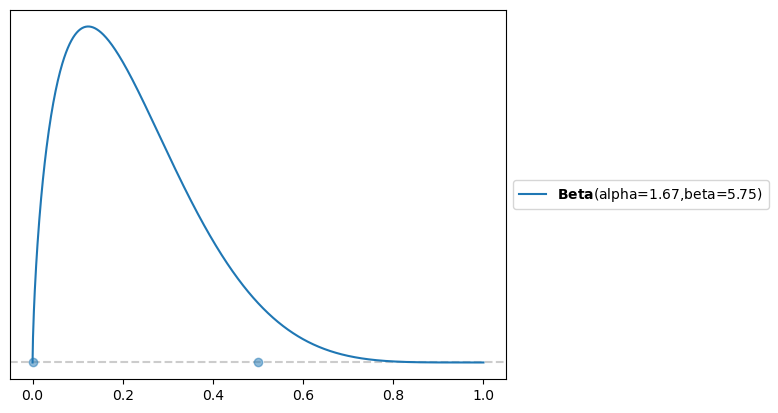

In [43]:
pz.maxent(pz.Beta(),0.0,0.5,0.95)
# pz.maxent(pz.Gamma(),50,200,0.90)

In [73]:
coords = {"pos": pos_codes,"player":player_codes}
with pm.Model(coords=coords) as football_model:
    μ = pm.Beta('μ', 1.7, 5.8) # Using preliz to define a prior with 95% of the mass between 0 and 0.5
    ν = pm.Gamma('ν', mu=125, sigma=50) # Maximum entropy with 90% of the values between 50 and 200
    
    # Parámetros por posición
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")

    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx],dims="player")
    
    _ = pm.Binomial('gs', n=football.tiros.values, p=θ, observed=football.goles.values)

    idata_football = pm.sample(2000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 462 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


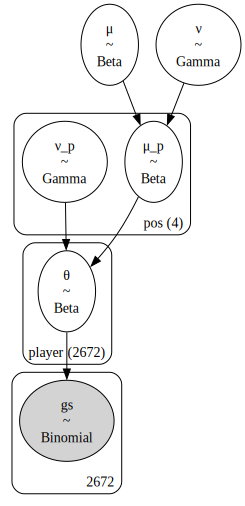

In [74]:
pm.model_to_graphviz(football_model)

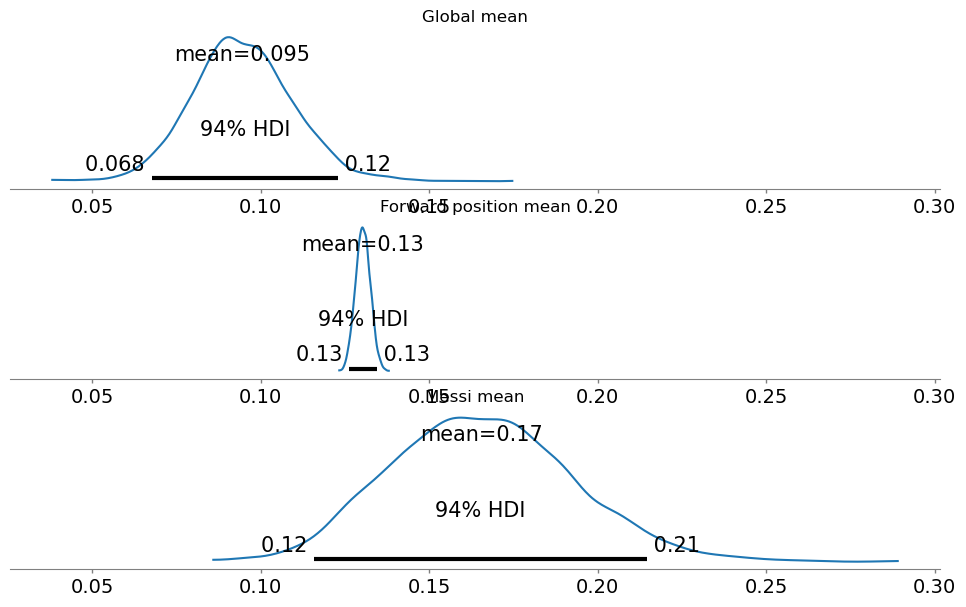

In [77]:
_, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
az.plot_posterior(idata_football, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_football.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_football.posterior.sel(player="Luis Suárez"), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean");

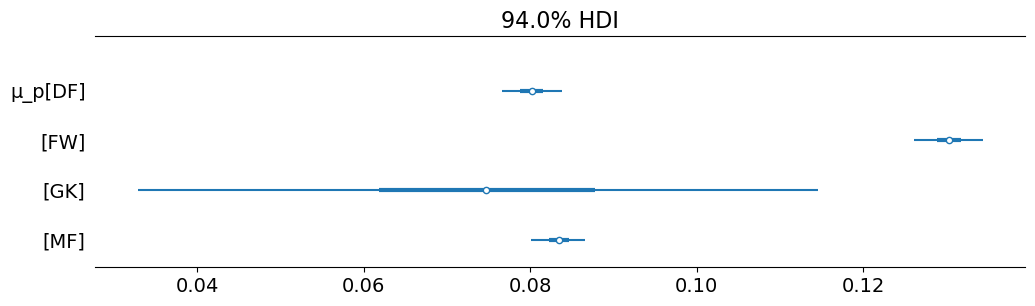

In [78]:
az.plot_forest(idata_football, var_names=['μ_p'], combined=True, figsize=(12, 3));

In [88]:
messi = idata_football.posterior.sel(player="Lionel Messi")['θ']
cr7 = idata_football.posterior.sel(player="Cristiano Ronaldo")['θ']

In [95]:
d_cohen = ((messi - cr7)/(np.sqrt(np.var(messi) + np.var(cr7)))).mean().item()

In [97]:
dist = pz.Normal(0,1)

In [98]:
ps = dist.cdf(d_cohen/(2**0.5))

In [99]:
ps

0.8197933898814366